In [2]:
import statsapi
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')


In [3]:
open_file = open(r"C:\Users\Haddon\OneDrive\Documents\Machine Learning Projects\Baseball Predictions\team_names.txt")

name_df = pd.read_csv(open_file, index_col = False)



In [4]:
name_df

name_list = name_df["team_names"].tolist()

In [5]:
count = 0
team_id_dict = {}
team_json = statsapi.get('teams', {'season': '2023'})
for team in team_json['teams']:
    # print(team["name"])
    # print(team["teamName"])
    if team["name"] in name_list:
        team_id_dict[team["name"]] = team["id"]
        print(team["name"])
        count += 1

print(count)

Los Angeles Angels
Arizona Diamondbacks
Baltimore Orioles
Boston Red Sox
Chicago Cubs
Cincinnati Reds
Cleveland Guardians
Colorado Rockies
Detroit Tigers
Houston Astros
Kansas City Royals
Los Angeles Dodgers
Washington Nationals
New York Mets
Oakland Athletics
Pittsburgh Pirates
San Diego Padres
Seattle Mariners
San Francisco Giants
St. Louis Cardinals
Tampa Bay Rays
Texas Rangers
Toronto Blue Jays
Minnesota Twins
Philadelphia Phillies
Atlanta Braves
Chicago White Sox
Miami Marlins
New York Yankees
Milwaukee Brewers
30


In [6]:
team_id_dict

{'Los Angeles Angels': 108,
 'Arizona Diamondbacks': 109,
 'Baltimore Orioles': 110,
 'Boston Red Sox': 111,
 'Chicago Cubs': 112,
 'Cincinnati Reds': 113,
 'Cleveland Guardians': 114,
 'Colorado Rockies': 115,
 'Detroit Tigers': 116,
 'Houston Astros': 117,
 'Kansas City Royals': 118,
 'Los Angeles Dodgers': 119,
 'Washington Nationals': 120,
 'New York Mets': 121,
 'Oakland Athletics': 133,
 'Pittsburgh Pirates': 134,
 'San Diego Padres': 135,
 'Seattle Mariners': 136,
 'San Francisco Giants': 137,
 'St. Louis Cardinals': 138,
 'Tampa Bay Rays': 139,
 'Texas Rangers': 140,
 'Toronto Blue Jays': 141,
 'Minnesota Twins': 142,
 'Philadelphia Phillies': 143,
 'Atlanta Braves': 144,
 'Chicago White Sox': 145,
 'Miami Marlins': 146,
 'New York Yankees': 147,
 'Milwaukee Brewers': 158}

In [7]:
teams_stats = statsapi.get('team_stats', {'season': '2023', 'stats': 'gameLog', 'group': 'hitting', 'teamId': 140})

In [8]:
hitting_stats = statsapi.get('team_stats', {'season': '2023', 'stats': 'gameLog', 'group': 'hitting', 'teamId': 140})

def process_hitting_data(hitting_stats):
    hitting_df = pd.DataFrame()
    for i in range(len(hitting_stats['stats'][0]['splits'])):
        row = hitting_stats['stats'][0]['splits'][i]['stat']

        temp_df = pd.DataFrame(row, index = [0])

        temp_df['team'] = hitting_stats["stats"][0]['splits'][i]['team']['id']
        temp_df["Date"] = hitting_stats['stats'][0]['splits'][i]['date']
        temp_df["gamePk"] = hitting_stats['stats'][0]['splits'][i]['game']['gamePk']
        temp_df["isWin"] = hitting_stats['stats'][0]['splits'][i]['isWin']
        temp_df["opponent"] = hitting_stats['stats'][0]['splits'][i]['opponent']['id']

        hitting_df = pd.concat([hitting_df, temp_df])

    return hitting_df 

hitting_df = process_hitting_data(hitting_stats)

In [9]:
pitch_stats = statsapi.get('team_stats', {'season': '2023', 'stats': 'gameLog', 'group': 'pitching', 'teamId': 140})

def process_pitch_data(pitch_stats):
    pitch_df = pd.DataFrame()
    for i in range(len(pitch_stats['stats'][0]['splits'])):
        row = pitch_stats['stats'][0]['splits'][i]['stat'] 

        temp_df = pd.DataFrame(row, index = [0])

        temp_df['team'] = pitch_stats["stats"][0]['splits'][i]['team']['id']
        temp_df["gamePk"] = pitch_stats['stats'][0]['splits'][i]['game']['gamePk']

        pitch_df = pd.concat([pitch_df, temp_df])
    return pitch_df

pitch_df = process_pitch_data(pitch_stats)


In [10]:
def combine_data(pitch_df, hitting_df):
    full_df = pitch_df.merge(hitting_df, how = 'inner', left_on = ['team', 'gamePk'], right_on = ["team", "gamePk"])

    rename_dict = {}
    for column in full_df.columns:
        if '_y' in column:
            rename_dict[column] = column.replace("y", "hitting")
        if '_x' in column:
            rename_dict[column] = column.replace("x", "pitching")

    full_df.rename(columns = rename_dict, inplace = True)

    return full_df 



In [11]:
seasons = [2018, 2019, 2020, 2021, 2022, 2023]
full_df = pd.DataFrame()
for i in list(team_id_dict.values()):
    for season in seasons:
        pitch_stats = statsapi.get('team_stats', {'season': str(season), 'stats': 'gameLog', 'group': 'pitching', 'teamId': i})
        hitting_stats = statsapi.get('team_stats', {'season': str(season), 'stats': 'gameLog', 'group': 'hitting', 'teamId': i})
        pitch_df = process_pitch_data(pitch_stats)
        hitting_df = process_hitting_data(hitting_stats)
        temp_df = combine_data(pitch_df, hitting_df)
        full_df = pd.concat([temp_df, full_df])

full_df.head()

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,...,rbi,leftOnBase,sacBunts_hitting,sacFlies_hitting,babip,groundOutsToAirouts_hitting,atBatsPerHomeRun,Date,isWin,opponent
0,1,1,13,6,4,0,0,0,5,4,...,0,7,0,0,.235,2.25,-.--,2023-03-30,False,112
1,1,1,11,5,1,1,0,1,10,1,...,3,6,0,0,.316,3.33,-.--,2023-04-01,True,112
2,1,1,10,7,5,1,0,2,8,4,...,9,10,0,3,.433,0.55,-.--,2023-04-02,True,112
3,1,1,7,10,0,0,0,0,9,6,...,10,8,0,0,.308,1.25,17.00,2023-04-03,True,121
4,1,1,8,15,0,0,0,0,3,0,...,9,4,0,0,.296,0.36,7.00,2023-04-04,True,121


In [12]:
full_df

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,...,rbi,leftOnBase,sacBunts_hitting,sacFlies_hitting,babip,groundOutsToAirouts_hitting,atBatsPerHomeRun,Date,isWin,opponent
0,1,1,13,6,4,0,0,0,5,4,...,0,7,0,0,.235,2.25,-.--,2023-03-30,False,112
1,1,1,11,5,1,1,0,1,10,1,...,3,6,0,0,.316,3.33,-.--,2023-04-01,True,112
2,1,1,10,7,5,1,0,2,8,4,...,9,10,0,3,.433,0.55,-.--,2023-04-02,True,112
3,1,1,7,10,0,0,0,0,9,6,...,10,8,0,0,.308,1.25,17.00,2023-04-03,True,121
4,1,1,8,15,0,0,0,0,3,0,...,9,4,0,0,.296,0.36,7.00,2023-04-04,True,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1,1,12,5,1,1,0,1,10,1,...,4,5,0,1,.192,0.62,-.--,2018-09-25,True,140
158,1,1,10,5,2,0,0,2,11,1,...,3,6,0,0,.176,1.80,13.50,2018-09-26,True,140
159,1,1,8,5,5,1,0,0,13,9,...,8,5,0,1,.292,0.70,15.50,2018-09-28,True,133
160,1,1,8,8,5,3,0,2,9,4,...,2,9,0,0,.167,0.67,-.--,2018-09-29,False,133


In [13]:
full_df["isWin"].replace("False", 0, inplace = True)
full_df["isWin"].replace("True", 1, inplace = True)

In [14]:
full_df.describe()

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,...,stolenBases_hitting,groundIntoDoublePlahitting_hitting,numberOfPitches_hitting,plateAppearances,totalBases_hitting,rbi,leftOnBase,sacBunts_hitting,sacFlies_hitting,opponent
count,26094.0,26094.0,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000,...,26094.000000,26094.000000,26094.000000,26094.000000,26094.00000,26094.000000,26094.000000,26094.000000,26094.000000,26094.000000
mean,1.0,1.0,8.488503,8.707826,4.548938,1.672760,0.149421,1.214532,8.600291,3.224458,...,0.530428,0.702997,147.680846,37.791676,13.95018,4.347666,6.743849,0.126849,0.244654,128.698781
std,0.0,0.0,2.765050,2.801391,3.215405,1.365275,0.395739,1.184201,2.973013,2.051444,...,0.860021,0.815672,22.943314,5.021746,6.61358,3.128552,2.605575,0.365204,0.498652,14.266099
min,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,62.000000,17.000000,0.00000,0.000000,0.000000,0.000000,0.000000,108.000000
25%,1.0,1.0,7.000000,7.000000,2.000000,1.000000,0.000000,0.000000,7.000000,2.000000,...,0.000000,0.000000,132.000000,34.000000,9.00000,2.000000,5.000000,0.000000,0.000000,115.000000
50%,1.0,1.0,8.000000,9.000000,4.000000,1.000000,0.000000,1.000000,8.000000,3.000000,...,0.000000,1.000000,146.000000,37.000000,13.00000,4.000000,7.000000,0.000000,0.000000,133.000000
75%,1.0,1.0,10.000000,11.000000,6.000000,2.000000,0.000000,2.000000,11.000000,4.000000,...,1.000000,1.000000,161.000000,41.000000,18.00000,6.000000,8.000000,0.000000,0.000000,141.000000
max,1.0,1.0,26.000000,24.000000,29.000000,11.000000,5.000000,8.000000,26.000000,17.000000,...,9.000000,6.000000,321.000000,74.000000,50.00000,28.000000,22.000000,4.000000,4.000000,158.000000


In [15]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094 entries, 0 to 161
Data columns (total 94 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   gamesPlayed_pitching                26094 non-null  int64 
 1   gamesStarted                        26094 non-null  int64 
 2   groundOuts_pitching                 26094 non-null  int64 
 3   airOuts_pitching                    26094 non-null  int64 
 4   runs_pitching                       26094 non-null  int64 
 5   doubles_pitching                    26094 non-null  int64 
 6   triples_pitching                    26094 non-null  int64 
 7   homeRuns_pitching                   26094 non-null  int64 
 8   strikeOuts_pitching                 26094 non-null  int64 
 9   baseOnBalls_pitching                26094 non-null  int64 
 10  intentionalWalks_pitching           26094 non-null  int64 
 11  hits_pitching                       26094 non-null  int6

In [16]:
for column in full_df.columns.tolist():
    if column != "Date":
        try: 
            full_df[column] = full_df[column].astype(float)
        except ValueError:
            full_df[column].replace(".---", 0, inplace = True)
            full_df[column].replace("-.--", 0, inplace = True)

for column in full_df.columns.tolist():
    if column != "Date":
        full_df[column] = full_df[column].astype(float)

full_df["Date"] = pd.to_datetime(full_df["Date"]).dt.date

full_df.reset_index(inplace = True, drop = True)

In [17]:
full_df["Date"].value_counts()

2020-09-04    40
2020-08-29    36
2023-08-19    36
2020-09-18    36
2022-05-08    36
              ..
2018-10-01     4
2019-07-11     2
2018-07-19     2
2019-03-20     2
2019-03-21     2
Name: Date, Length: 979, dtype: int64

In [18]:
full_df

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,...,rbi,leftOnBase,sacBunts_hitting,sacFlies_hitting,babip,groundOutsToAirouts_hitting,atBatsPerHomeRun,Date,isWin,opponent
0,1.0,1.0,13.0,6.0,4.0,0.0,0.0,0.0,5.0,4.0,...,0.0,7.0,0.0,0.0,0.235,2.25,0.0,2023-03-30,0.0,112.0
1,1.0,1.0,11.0,5.0,1.0,1.0,0.0,1.0,10.0,1.0,...,3.0,6.0,0.0,0.0,0.316,3.33,0.0,2023-04-01,1.0,112.0
2,1.0,1.0,10.0,7.0,5.0,1.0,0.0,2.0,8.0,4.0,...,9.0,10.0,0.0,3.0,0.433,0.55,0.0,2023-04-02,1.0,112.0
3,1.0,1.0,7.0,10.0,0.0,0.0,0.0,0.0,9.0,6.0,...,10.0,8.0,0.0,0.0,0.308,1.25,17.0,2023-04-03,1.0,121.0
4,1.0,1.0,8.0,15.0,0.0,0.0,0.0,0.0,3.0,0.0,...,9.0,4.0,0.0,0.0,0.296,0.36,7.0,2023-04-04,1.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26089,1.0,1.0,12.0,5.0,1.0,1.0,0.0,1.0,10.0,1.0,...,4.0,5.0,0.0,1.0,0.192,0.62,0.0,2018-09-25,1.0,140.0
26090,1.0,1.0,10.0,5.0,2.0,0.0,0.0,2.0,11.0,1.0,...,3.0,6.0,0.0,0.0,0.176,1.80,13.5,2018-09-26,1.0,140.0
26091,1.0,1.0,8.0,5.0,5.0,1.0,0.0,0.0,13.0,9.0,...,8.0,5.0,0.0,1.0,0.292,0.70,15.5,2018-09-28,1.0,133.0
26092,1.0,1.0,8.0,8.0,5.0,3.0,0.0,2.0,9.0,4.0,...,2.0,9.0,0.0,0.0,0.167,0.67,0.0,2018-09-29,0.0,133.0


In [19]:
full_df["rbi_per_atBats"] = full_df["rbi"]/full_df["atBats_hitting"]
full_df["strikeOuts_per_atBats"] = full_df["strikeOuts_hitting"]/full_df["atBats_hitting"]
full_df["doubles_per_atBats"] = full_df["doubles_hitting"]/full_df["atBats_hitting"]
full_df["strikeOuts_per_atBats"] = full_df["strikeOuts_hitting"]/full_df["atBats_hitting"]




<Axes: >

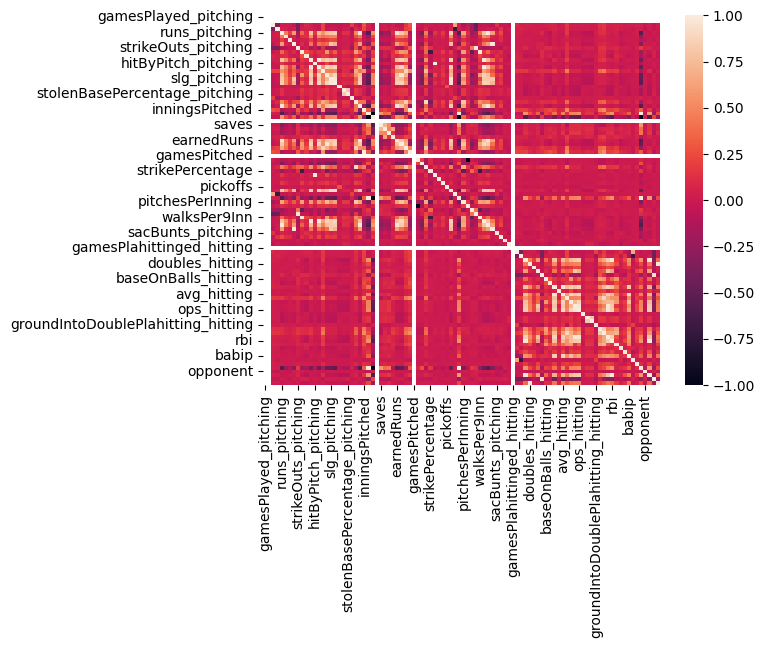

In [20]:
sns.heatmap(full_df.corr())

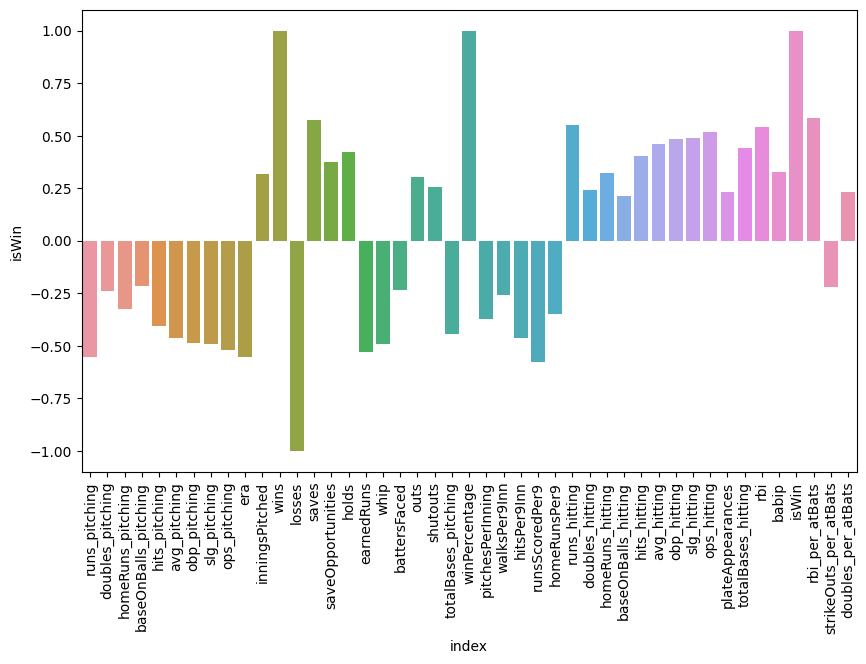

In [22]:
corr_df = full_df.corr()

# Set the figure size
plt.figure(figsize=(10, 6)) 

isWin_df = corr_df[["isWin"]]
isWin_df.reset_index(inplace = True)
ax = sns.barplot(isWin_df[(isWin_df["isWin"] > .20) | (isWin_df["isWin"] < -.20)], x = "index", y = "isWin")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [23]:
feature_df = isWin_df[(isWin_df["isWin"] > .20) | (isWin_df["isWin"] < -.20)]
feature_names = feature_df["index"].tolist()

In [24]:
feature_names

['runs_pitching',
 'doubles_pitching',
 'homeRuns_pitching',
 'baseOnBalls_pitching',
 'hits_pitching',
 'avg_pitching',
 'obp_pitching',
 'slg_pitching',
 'ops_pitching',
 'era',
 'inningsPitched',
 'wins',
 'losses',
 'saves',
 'saveOpportunities',
 'holds',
 'earnedRuns',
 'whip',
 'battersFaced',
 'outs',
 'shutouts',
 'totalBases_pitching',
 'winPercentage',
 'pitchesPerInning',
 'walksPer9Inn',
 'hitsPer9Inn',
 'runsScoredPer9',
 'homeRunsPer9',
 'runs_hitting',
 'doubles_hitting',
 'homeRuns_hitting',
 'baseOnBalls_hitting',
 'hits_hitting',
 'avg_hitting',
 'obp_hitting',
 'slg_hitting',
 'ops_hitting',
 'plateAppearances',
 'totalBases_hitting',
 'rbi',
 'babip',
 'isWin',
 'rbi_per_atBats',
 'strikeOuts_per_atBats',
 'doubles_per_atBats']

In [25]:
full_df["Date"].value_counts()

2020-09-04    40
2020-08-29    36
2023-08-19    36
2020-09-18    36
2022-05-08    36
              ..
2018-10-01     4
2019-07-11     2
2018-07-19     2
2019-03-20     2
2019-03-21     2
Name: Date, Length: 979, dtype: int64

In [26]:
hitting_col = ["rbi", "obp", "slg", "ops", "leftOnBase", "babip"]

In [27]:
full_df.reset_index

<bound method DataFrame.reset_index of        gamesPlayed_pitching  gamesStarted  groundOuts_pitching  \
0                       1.0           1.0                 13.0   
1                       1.0           1.0                 11.0   
2                       1.0           1.0                 10.0   
3                       1.0           1.0                  7.0   
4                       1.0           1.0                  8.0   
...                     ...           ...                  ...   
26089                   1.0           1.0                 12.0   
26090                   1.0           1.0                 10.0   
26091                   1.0           1.0                  8.0   
26092                   1.0           1.0                  8.0   
26093                   1.0           1.0                  7.0   

       airOuts_pitching  runs_pitching  doubles_pitching  triples_pitching  \
0                   6.0            4.0               0.0               0.0   
1           

In [110]:
def find_weighted_rolling_avg(dur, value_col, weight_col, df, date_val, team):
    avg_df = pd.DataFrame()
    team_df = df[df["team"]==team]
    #print(team_df)
    team_df.sort_values("Date", ascending = True, inplace = True)
    team_df.reset_index(inplace=True, drop = True)
    games_on_date = len(team_df[team_df["Date"] == date_val])
    if games_on_date == 0:
        pass
        return
    elif games_on_date >= 1:
        #print("grabbed")
        for i in range(games_on_date): 
            max_date_ind = max(team_df[team_df["Date"] == date_val].index.values) - 1 - i
            if max_date_ind <= dur:
                pass
            else:
                #print(max_date_ind[0])
                start_row = max_date_ind - dur 
                #print(start_row[0])
                sub_df = team_df.iloc[start_row:max_date_ind+1]
                calc_df = team_df.iloc[start_row:max_date_ind]
                #print(sub_df)
                calc_df[f'wt_val_{value_col}'] = calc_df[weight_col] * calc_df[value_col]
                weighted_avg = calc_df[f'wt_val_{value_col}'].sum() / calc_df[weight_col].sum()
                sub_df.loc[max_date_ind, f"wt_avg_{value_col}"] = weighted_avg
                avg_df = pd.concat([avg_df, sub_df.loc[[max_date_ind]]])
        return avg_df


In [111]:
proc_df = pd.DataFrame()
for i in ['avg_hitting','obp_hitting','slg_hitting','ops_hitting','rbi_per_atBats']:
# for i in ['avg_hitting']:
    for date_i in pd.to_datetime(full_df["Date"]).dt.date.unique().tolist():
        for team_i in full_df["team"].unique().tolist():
            temp_df = find_weighted_rolling_avg(5, i, "atBats_hitting", full_df, date_i, team_i)
            if temp_df is None:
                pass
            else:
                proc_df = pd.concat([temp_df, proc_df])

KeyboardInterrupt: 

In [102]:
temp_df

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,...,groundOutsToAirouts_hitting,atBatsPerHomeRun,Date,isWin,opponent,rbi_per_atBats,strikeOuts_per_atBats,doubles_per_atBats,wt_avg_avg_hitting,wt_val_avg_hitting
717,1.0,1.0,13.0,10.0,6.0,2.0,2.0,0.0,4.0,5.0,...,0.4,0.0,2023-04-09,1.0,119.0,0.275,0.25,0.1,0.315766,16.0


In [103]:
full_df[full_df.duplicated(keep=False)]

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,...,babip,groundOutsToAirouts_hitting,atBatsPerHomeRun,Date,isWin,opponent,rbi_per_atBats,strikeOuts_per_atBats,doubles_per_atBats,wt_avg_avg_hitting


In [105]:
proc_df

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,...,groundOutsToAirouts_hitting,atBatsPerHomeRun,Date,isWin,opponent,rbi_per_atBats,strikeOuts_per_atBats,doubles_per_atBats,wt_avg_avg_hitting,wt_val_avg_hitting
717,1.0,1.0,13.0,10.0,6.0,2.0,2.0,0.0,4.0,5.0,...,0.40,0.0,2023-04-09,1.0,119.0,0.275000,0.250000,0.100000,0.315766,16.000
716,1.0,1.0,7.0,9.0,5.0,1.0,0.0,3.0,10.0,1.0,...,0.25,32.0,2023-04-09,0.0,147.0,0.093750,0.343750,0.062500,0.180000,6.016
716,1.0,1.0,9.0,8.0,1.0,2.0,0.0,0.0,10.0,1.0,...,1.43,32.0,2023-04-09,1.0,116.0,0.125000,0.281250,0.062500,0.221788,7.008
716,1.0,1.0,9.0,10.0,8.0,5.0,1.0,0.0,10.0,2.0,...,1.14,31.0,2023-04-09,0.0,140.0,0.064516,0.290323,0.000000,0.301882,7.006
715,1.0,1.0,7.0,7.0,4.0,1.0,1.0,1.0,9.0,3.0,...,6.00,0.0,2023-04-09,1.0,143.0,0.187500,0.375000,0.093750,0.247505,6.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,1.0,1.0,6.0,11.0,12.0,0.0,2.0,2.0,5.0,6.0,...,0.60,20.5,2022-10-05,0.0,146.0,0.219512,0.268293,0.170732,0.260163,15.006
706,1.0,1.0,6.0,9.0,10.0,3.0,0.0,2.0,11.0,6.0,...,1.33,0.0,2022-10-05,0.0,142.0,0.028571,0.171429,0.085714,0.205364,8.015
706,1.0,1.0,6.0,10.0,9.0,7.0,0.0,2.0,11.0,3.0,...,0.55,17.5,2022-10-05,1.0,144.0,0.314286,0.142857,0.000000,0.222792,12.985
707,1.0,1.0,9.0,5.0,4.0,2.0,0.0,2.0,7.0,3.0,...,1.00,30.0,2022-10-05,0.0,140.0,0.066667,0.300000,0.000000,0.235171,5.010


In [266]:
proc_df.wt_avg_avg_hitting.info()

<class 'pandas.core.series.Series'>
Int64Index: 2609400 entries, 0 to 161
Series name: wt_avg_avg_hitting
Non-Null Count  Dtype  
--------------  -----  
72000 non-null  float64
dtypes: float64(1)
memory usage: 39.8 MB


In [210]:
temp_df.columns

Index(['gamesPlayed_pitching', 'gamesStarted', 'groundOuts_pitching',
       'airOuts_pitching', 'runs_pitching', 'doubles_pitching',
       'triples_pitching', 'homeRuns_pitching', 'strikeOuts_pitching',
       'baseOnBalls_pitching', 'intentionalWalks_pitching', 'hits_pitching',
       'hitByPitch_pitching', 'avg_pitching', 'atBats_pitching',
       'obp_pitching', 'slg_pitching', 'ops_pitching',
       'caughtStealing_pitching', 'stolenBases_pitching',
       'stolenBasePercentage_pitching', 'groundIntoDoublePlay_pitching',
       'numberOfPitches_pitching', 'era', 'inningsPitched', 'wins', 'losses',
       'ties', 'saves', 'saveOpportunities', 'holds', 'blownSaves',
       'earnedRuns', 'whip', 'battersFaced', 'outs', 'gamesPitched',
       'completeGames', 'shutouts', 'strikes', 'strikePercentage',
       'hitBatsmen', 'balks', 'wildPitches', 'pickoffs', 'totalBases_pitching',
       'groundOutsToAirouts_pitching', 'winPercentage', 'pitchesPerInning',
       'gamesFinished', 'stri

In [203]:
proc_df

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,intentionalWalks_pitching,hits_pitching,hitByPitch_pitching,avg_pitching,atBats_pitching,obp_pitching,slg_pitching,ops_pitching,caughtStealing_pitching,stolenBases_pitching,stolenBasePercentage_pitching,groundIntoDoublePlay_pitching,numberOfPitches_pitching,era,inningsPitched,wins,losses,ties,saves,saveOpportunities,holds,blownSaves,earnedRuns,whip,battersFaced,outs,gamesPitched,completeGames,shutouts,strikes,strikePercentage,hitBatsmen,balks,wildPitches,pickoffs,totalBases_pitching,groundOutsToAirouts_pitching,winPercentage,pitchesPerInning,gamesFinished,strikeoutWalkRatio,strikeoutsPer9Inn,walksPer9Inn,hitsPer9Inn,runsScoredPer9,homeRunsPer9,sacBunts_pitching,sacFlies_pitching,team,gamePk,gamesPlahittinged_hitting,groundOuts_hitting,airOuts_hitting,runs_hitting,doubles_hitting,triples_hitting,homeRuns_hitting,strikeOuts_hitting,baseOnBalls_hitting,intentionalWalks_hitting,hits_hitting,hitBhittingPitch_hitting,avg_hitting,atBats_hitting,obp_hitting,slg_hitting,ops_hitting,caughtStealing_hitting,stolenBases_hitting,stolenBasePercentage_hitting,groundIntoDoublePlahitting_hitting,numberOfPitches_hitting,plateAppearances,totalBases_hitting,rbi,leftOnBase,sacBunts_hitting,sacFlies_hitting,babip,groundOutsToAirouts_hitting,atBatsPerHomeRun,Date,isWin,opponent,rbi_per_atBats,strikeOuts_per_atBats,doubles_per_atBats,babip_per_atBats
0,1.0,1.0,13.0,6.0,4.0,0.0,0.0,0.0,5.0,4.0,0.0,6.0,1.0,0.200,30.0,0.314,0.200,0.514,0.0,0.0,0.0,1.0,124.0,4.5,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,35.0,24.0,1.0,0.0,0.0,81.0,0.65,1.0,0.0,0.0,0.0,6.0,2.17,0.0,15.50,1.0,1.25,5.63,4.5,6.75,4.5,0.0,0.0,0.0,158.0,718777.0,1.0,9.0,4.0,0.0,0.0,0.0,0.0,12.0,5.0,0.0,4.0,0.0,0.138,29.0,0.265,0.138,0.403,0.0,0.0,0.0,2.0,133.0,34.0,4.0,0.0,7.0,0.0,0.0,0.235,2.25,0.0,2023-03-30,0.0,112.0,0.000000,0.413793,0.000000,0.008103
1,1.0,1.0,11.0,5.0,1.0,1.0,0.0,1.0,10.0,1.0,0.0,5.0,0.0,0.161,31.0,0.188,0.290,0.478,0.0,0.0,0.0,1.0,143.0,1.0,9.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.67,32.0,27.0,1.0,0.0,0.0,97.0,0.68,0.0,0.0,0.0,0.0,9.0,2.20,1.0,15.89,1.0,10.00,10.00,1.0,5.00,1.0,1.0,0.0,0.0,158.0,718758.0,1.0,10.0,3.0,3.0,1.0,0.0,0.0,13.0,4.0,0.0,6.0,0.0,0.188,32.0,0.278,0.219,0.497,0.0,1.0,1.0,1.0,144.0,36.0,7.0,3.0,6.0,0.0,0.0,0.316,3.33,0.0,2023-04-01,1.0,112.0,0.093750,0.406250,0.031250,0.009875
2,1.0,1.0,10.0,7.0,5.0,1.0,0.0,2.0,8.0,4.0,0.0,9.0,0.0,0.273,33.0,0.342,0.485,0.827,1.0,1.0,0.5,1.0,149.0,5.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.44,38.0,27.0,1.0,0.0,0.0,84.0,0.56,0.0,0.0,1.0,0.0,16.0,1.43,1.0,16.56,1.0,2.00,8.00,4.0,9.00,5.0,2.0,0.0,1.0,158.0,718738.0,1.0,6.0,11.0,9.0,2.0,1.0,0.0,10.0,6.0,0.0,13.0,0.0,0.351,37.0,0.413,0.459,0.872,0.0,0.0,0.0,0.0,168.0,46.0,17.0,9.0,10.0,0.0,3.0,0.433,0.55,0.0,2023-04-02,1.0,112.0,0.243243,0.270270,0.054054,0.011703
3,1.0,1.0,7.0,10.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,3.0,1.0,0.103,29.0,0.278,0.103,0.381,0.0,0.0,0.0,0.0,134.0,0.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.00,36.0,27.0,1.0,0.0,1.0,75.0,0.56,1.0,0.0,0.0,0.0,3.0,0.70,1.0,14.89,1.0,1.50,9.00,6.0,3.00,0.0,0.0,0.0,0.0,158.0,718731.0,1.0,10.0,8.0,10.0,0.0,0.0,2.0,6.0,8.0,0.0,10.0,0.0,0.294,34.0,0.429,0.471,0.900,0.0,2.0,1.0,0.0,180.0,42.0,16.0,10.0,8.0,0.0,0.0,0.308,1.25,17.0,2023-04-03,1.0,121.0,0.294118,0.176471,0.000000,0.009059
4,1.0,1.0,8.0,15.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,8.0,1.0,0.235,34.0,0.257,0.235,0.492,0.0,0.0,0.0,1.0,128.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.89,35.0,27.0,1.0,0.0,1.0,81.0,0.63,1.0,0.0,0.0,0.0,8.0,0.53,1.0,14.22,1.0,0.00,3.00,0.0,8.00,0.0,0.0,0.0,0.0,158.0,718712.0,1.0,5.0,14.0,9.0,1.0,0.0,5.0,3.0,2.0,0.0,13.0,0.0,0.371,35.0,0.405,0.829,1.234,0.0,1.0,1.0,1.0,144.0,37.0,29.0,9.0,4.0,0.0,0.0,0.296,0.36,7.0,2023-04-04,1.0,121.0,0.257143,0.085714,0.028571,0.008457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [198]:
proc_df = pd.DataFrame()
for i in ['avg_hitting','obp_hitting','slg_hitting','ops_hitting','rbi_per_atBats']:
    for date_i in full_df["Date"].unique().tolist():
        for team_i in full_df["team"].unique().tolist():
            temp_df = find_weighted_rolling_avg(5, i, "atBats", full_df, date_i, team_i)
            proc_df = pd.concat([temp_df, proc_df])


C:\Users\Haddon\AppData\Local\Temp\ipykernel_10148\1987125444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df.sort_values("Date", ascending = True, inplace = True)
C:\Users\Haddon\AppData\Local\Temp\ipykernel_10148\1987125444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df.sort_values("Date", ascending = True, inplace = True)
C:\Users\Haddon\AppData\Local\Temp\ipykernel_10148\1987125444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

KeyboardInterrupt: 

In [199]:
proc_df

,gamesPlayed_pitching,gamesStarted,groundOuts_pitching,airOuts_pitching,runs_pitching,doubles_pitching,triples_pitching,homeRuns_pitching,strikeOuts_pitching,baseOnBalls_pitching,intentionalWalks_pitching,hits_pitching,hitByPitch_pitching,avg_pitching,atBats_pitching,obp_pitching,slg_pitching,ops_pitching,caughtStealing_pitching,stolenBases_pitching,stolenBasePercentage_pitching,groundIntoDoublePlay_pitching,numberOfPitches_pitching,era,inningsPitched,wins,losses,ties,saves,saveOpportunities,holds,blownSaves,earnedRuns,whip,battersFaced,outs,gamesPitched,completeGames,shutouts,strikes,strikePercentage,hitBatsmen,balks,wildPitches,pickoffs,totalBases_pitching,groundOutsToAirouts_pitching,winPercentage,pitchesPerInning,gamesFinished,strikeoutWalkRatio,strikeoutsPer9Inn,walksPer9Inn,hitsPer9Inn,runsScoredPer9,homeRunsPer9,sacBunts_pitching,sacFlies_pitching,team,gamePk,gamesPlahittinged_hitting,groundOuts_hitting,airOuts_hitting,runs_hitting,doubles_hitting,triples_hitting,homeRuns_hitting,strikeOuts_hitting,baseOnBalls_hitting,intentionalWalks_hitting,hits_hitting,hitBhittingPitch_hitting,avg_hitting,atBats_hitting,obp_hitting,slg_hitting,ops_hitting,caughtStealing_hitting,stolenBases_hitting,stolenBasePercentage_hitting,groundIntoDoublePlahitting_hitting,numberOfPitches_hitting,plateAppearances,totalBases_hitting,rbi,leftOnBase,sacBunts_hitting,sacFlies_hitting,babip,groundOutsToAirouts_hitting,atBatsPerHomeRun,Date,isWin,opponent,rbi_per_atBats,strikeOuts_per_atBats,doubles_per_atBats,babip_per_atBats
0,1.0,1.0,13.0,6.0,4.0,0.0,0.0,0.0,5.0,4.0,0.0,6.0,1.0,0.200,30.0,0.314,0.200,0.514,0.0,0.0,0.0,1.0,124.0,4.5,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.25,35.0,24.0,1.0,0.0,0.0,81.0,0.65,1.0,0.0,0.0,0.0,6.0,2.17,0.0,15.50,1.0,1.25,5.63,4.5,6.75,4.5,0.0,0.0,0.0,158.0,718777.0,1.0,9.0,4.0,0.0,0.0,0.0,0.0,12.0,5.0,0.0,4.0,0.0,0.138,29.0,0.265,0.138,0.403,0.0,0.0,0.0,2.0,133.0,34.0,4.0,0.0,7.0,0.0,0.0,0.235,2.25,0.0,2023-03-30,0.0,112.0,0.000000,0.413793,0.000000,0.008103
1,1.0,1.0,11.0,5.0,1.0,1.0,0.0,1.0,10.0,1.0,0.0,5.0,0.0,0.161,31.0,0.188,0.290,0.478,0.0,0.0,0.0,1.0,143.0,1.0,9.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.67,32.0,27.0,1.0,0.0,0.0,97.0,0.68,0.0,0.0,0.0,0.0,9.0,2.20,1.0,15.89,1.0,10.00,10.00,1.0,5.00,1.0,1.0,0.0,0.0,158.0,718758.0,1.0,10.0,3.0,3.0,1.0,0.0,0.0,13.0,4.0,0.0,6.0,0.0,0.188,32.0,0.278,0.219,0.497,0.0,1.0,1.0,1.0,144.0,36.0,7.0,3.0,6.0,0.0,0.0,0.316,3.33,0.0,2023-04-01,1.0,112.0,0.093750,0.406250,0.031250,0.009875
2,1.0,1.0,10.0,7.0,5.0,1.0,0.0,2.0,8.0,4.0,0.0,9.0,0.0,0.273,33.0,0.342,0.485,0.827,1.0,1.0,0.5,1.0,149.0,5.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.44,38.0,27.0,1.0,0.0,0.0,84.0,0.56,0.0,0.0,1.0,0.0,16.0,1.43,1.0,16.56,1.0,2.00,8.00,4.0,9.00,5.0,2.0,0.0,1.0,158.0,718738.0,1.0,6.0,11.0,9.0,2.0,1.0,0.0,10.0,6.0,0.0,13.0,0.0,0.351,37.0,0.413,0.459,0.872,0.0,0.0,0.0,0.0,168.0,46.0,17.0,9.0,10.0,0.0,3.0,0.433,0.55,0.0,2023-04-02,1.0,112.0,0.243243,0.270270,0.054054,0.011703
3,1.0,1.0,7.0,10.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,3.0,1.0,0.103,29.0,0.278,0.103,0.381,0.0,0.0,0.0,0.0,134.0,0.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.00,36.0,27.0,1.0,0.0,1.0,75.0,0.56,1.0,0.0,0.0,0.0,3.0,0.70,1.0,14.89,1.0,1.50,9.00,6.0,3.00,0.0,0.0,0.0,0.0,158.0,718731.0,1.0,10.0,8.0,10.0,0.0,0.0,2.0,6.0,8.0,0.0,10.0,0.0,0.294,34.0,0.429,0.471,0.900,0.0,2.0,1.0,0.0,180.0,42.0,16.0,10.0,8.0,0.0,0.0,0.308,1.25,17.0,2023-04-03,1.0,121.0,0.294118,0.176471,0.000000,0.009059
4,1.0,1.0,8.0,15.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,8.0,1.0,0.235,34.0,0.257,0.235,0.492,0.0,0.0,0.0,1.0,128.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.89,35.0,27.0,1.0,0.0,1.0,81.0,0.63,1.0,0.0,0.0,0.0,8.0,0.53,1.0,14.22,1.0,0.00,3.00,0.0,8.00,0.0,0.0,0.0,0.0,158.0,718712.0,1.0,5.0,14.0,9.0,1.0,0.0,5.0,3.0,2.0,0.0,13.0,0.0,0.371,35.0,0.405,0.829,1.234,0.0,1.0,1.0,1.0,144.0,37.0,29.0,9.0,4.0,0.0,0.0,0.296,0.36,7.0,2023-04-04,1.0,121.0,0.257143,0.085714,0.028571,0.008457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [196]:
full_df.columns

Index(['gamesPlayed_pitching', 'gamesStarted', 'groundOuts_pitching',
       'airOuts_pitching', 'runs_pitching', 'doubles_pitching',
       'triples_pitching', 'homeRuns_pitching', 'strikeOuts_pitching',
       'baseOnBalls_pitching', 'intentionalWalks_pitching', 'hits_pitching',
       'hitByPitch_pitching', 'avg_pitching', 'atBats_pitching',
       'obp_pitching', 'slg_pitching', 'ops_pitching',
       'caughtStealing_pitching', 'stolenBases_pitching',
       'stolenBasePercentage_pitching', 'groundIntoDoublePlay_pitching',
       'numberOfPitches_pitching', 'era', 'inningsPitched', 'wins', 'losses',
       'ties', 'saves', 'saveOpportunities', 'holds', 'blownSaves',
       'earnedRuns', 'whip', 'battersFaced', 'outs', 'gamesPitched',
       'completeGames', 'shutouts', 'strikes', 'strikePercentage',
       'hitBatsmen', 'balks', 'wildPitches', 'pickoffs', 'totalBases_pitching',
       'groundOutsToAirouts_pitching', 'winPercentage', 'pitchesPerInning',
       'gamesFinished', 'stri

In [64]:
statsapi.meta('statGroups')

[{'displayName': 'hitting'},
 {'displayName': 'pitching'},
 {'displayName': 'fielding'},
 {'displayName': 'catching'},
 {'displayName': 'running'},
 {'displayName': 'game'},
 {'displayName': 'team'},
 {'displayName': 'streak'}]

In [65]:
statsapi.meta('statTypes')

[{'displayName': 'projected'},
 {'displayName': 'projectedRos'},
 {'displayName': 'yearByYear'},
 {'displayName': 'yearByYearAdvanced'},
 {'displayName': 'yearByYearPlayoffs'},
 {'displayName': 'season'},
 {'displayName': 'standard'},
 {'displayName': 'advanced'},
 {'displayName': 'career'},
 {'displayName': 'careerRegularSeason'},
 {'displayName': 'careerAdvanced'},
 {'displayName': 'seasonAdvanced'},
 {'displayName': 'careerStatSplits'},
 {'displayName': 'careerPlayoffs'},
 {'displayName': 'gameLog'},
 {'displayName': 'playLog'},
 {'displayName': 'pitchLog'},
 {'displayName': 'metricLog'},
 {'displayName': 'metricAverages'},
 {'displayName': 'pitchArsenal'},
 {'displayName': 'outsAboveAverage'},
 {'displayName': 'expectedStatistics'},
 {'displayName': 'sabermetrics'},
 {'displayName': 'sprayChart'},
 {'displayName': 'tracking'},
 {'displayName': 'vsPlayer'},
 {'displayName': 'vsPlayerTotal'},
 {'displayName': 'vsPlayer5Y'},
 {'displayName': 'vsTeam'},
 {'displayName': 'vsTeam5Y'},
 {